## Initialization

Mount Google Drive to access data and other repo files

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Set the seed for reproducability

In [2]:
import torch
import numpy as np
import random

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

Clone the repository to access the other relevant files

In [3]:
# clone the repo
!git clone https://github.com/lgiesen/Deep-Self-Learning-From-Noisy-Labels.git

# go to directory
%cd Deep-Self-Learning-From-Noisy-Labels

Cloning into 'Deep-Self-Learning-From-Noisy-Labels'...
remote: Enumerating objects: 220, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 220 (delta 13), reused 18 (delta 13), pack-reused 200
Receiving objects: 100% (220/220), 87.96 MiB | 16.55 MiB/s, done.
Resolving deltas: 100% (125/125), done.
/content/Deep-Self-Learning-From-Noisy-Labels


## Data Preparation 

Define the dataset

In [4]:
from config import batch_size, dataset_test_path, dataset_train_path, dataset_val_path
from LoadDataset import CustomImageDataset
from torch.utils.data import DataLoader
from torchvision import transforms

# Define the transformations
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # "These exact values are used for normalizing data that has been pre-trained
    # on the ImageNet dataset. They are based on the statistics of the ImageNet
    # dataset, which consists of a large number of natural images."
    # https://moiseevigor.github.io/software/2022/12/18/one-pager-training-resnet-on-imagenet/

])

# Create datasets
train_dataset = CustomImageDataset(file_path=dataset_train_path, transform=transform)
val_dataset = CustomImageDataset(file_path=dataset_val_path, transform=transform)
test_dataset = CustomImageDataset(file_path=dataset_test_path, transform=transform)

# Create data loaders
# pinned memory can significantly speed up the transfer of data between the host and the device (GPU) because the GPU can directly access it
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
%cd ../../

/


Extract the image files

In [5]:
"""
time to extract all 9 tar files: 
CPU times: user 3min 46s, sys: 6min 13s, total: 10min
Wall time: 6min 6s
"""
import tarfile
import os
from config import shared_folder_path, dataset_img

# Function to extract and process files
def extract_and_process(tar_file_path, extract_to):
    with tarfile.open(tar_file_path, 'r') as tar_ref:
        tar_ref.extractall(extract_to)
        print(f"Extracted {tar_file_path} to {extract_to}")

parallel_extraction = True

from concurrent.futures import ThreadPoolExecutor

# Function to extract and process files
def extract_and_process(tar_file_path, extract_to):
    with tarfile.open(tar_file_path, 'r') as tar_ref:
        tar_ref.extractall(extract_to)
        print(f"Extracted {tar_file_path} to {extract_to}")

# Create the extraction directory if it doesn't exist
os.makedirs(dataset_img, exist_ok=True)

# List of tar files to extract
tar_files = [os.path.join(shared_folder_path, f"{i}.tar") for i in range(10)]

# Function to handle extraction in parallel
def extract_tar_files_parallel(tar_files, extract_to):
    with ThreadPoolExecutor() as executor:
        futures = [executor.submit(extract_and_process, tar_file, extract_to) for tar_file in tar_files if os.path.exists(tar_file)]
        for future in futures:
            try:
                future.result()  # Wait for the result to ensure any exceptions are raised
            except Exception as e:
                print(f"An error occurred: {e}")

# Extract tar files in parallel
extract_tar_files_parallel(tar_files, dataset_img)
print("The extracted tar files should result in the folders 0 to 9:")
!ls "{dataset_img}"

Extracted /content/drive/MyDrive/Colab_Notebooks/Deep_Self_Learning_From_Noisy_Labels/images/3.tar to ../drive/MyDrive/Colab_Notebooks/Deep_Self_Learning_From_Noisy_Labels/extracted_images/
Extracted /content/drive/MyDrive/Colab_Notebooks/Deep_Self_Learning_From_Noisy_Labels/images/0.tar to ../drive/MyDrive/Colab_Notebooks/Deep_Self_Learning_From_Noisy_Labels/extracted_images/
Extracted /content/drive/MyDrive/Colab_Notebooks/Deep_Self_Learning_From_Noisy_Labels/images/4.tar to ../drive/MyDrive/Colab_Notebooks/Deep_Self_Learning_From_Noisy_Labels/extracted_images/
Extracted /content/drive/MyDrive/Colab_Notebooks/Deep_Self_Learning_From_Noisy_Labels/images/1.tar to ../drive/MyDrive/Colab_Notebooks/Deep_Self_Learning_From_Noisy_Labels/extracted_images/
Extracted /content/drive/MyDrive/Colab_Notebooks/Deep_Self_Learning_From_Noisy_Labels/images/2.tar to ../drive/MyDrive/Colab_Notebooks/Deep_Self_Learning_From_Noisy_Labels/extracted_images/
Extracted /content/drive/MyDrive/Colab_Notebooks/D

## Training

Define the model

In [ ]:
import torch
from torchvision import models
from config import lr, momentum, weight_decay, gamma, step_size, dataset, num_classes
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd
import numpy as np
import torch

# check if the GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")
# initialize the model
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
# modify the final fully connected layer to output 14 classes
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, num_classes)
# parallelize training across multiple GPUs
model = torch.nn.DataParallel(model)
# calculate the balanced class weights because of an imbalanced dataset
# read the data again for higher efficiency
data = pd.read_csv(dataset.replace("../","/content/"), header=None, sep=' ', usecols=[1], names=['label'])
# convert the labels to a numpy array
labels = data['label'].values
# compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
del labels, data
# define the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
# initialize the learning rate scheduler: Decay LR by a factor of 0.1 every 5 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
# push the model to the GPU
model = model.to(device)

device: cuda:0


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 74.1MB/s]


Define functions to evaluate the model during training

Train the model

In [ ]:
from scripts.supportfunctions import evaluate_model, calculate_accuracy
import time
from config import num_epochs, dataset_root, checkpoint_path
from torch.utils.tensorboard import SummaryWriter

# Initialize TensorBoard writer
writer_path = dataset_root.replace("..", "/content") + 'runs/resnet50_experiment'
writer = SummaryWriter(writer_path)

# Early stopping parameters
patience = 5
best_val_loss = float('inf')
epochs_no_improve = 0
early_stop = False

# Train the model
for epoch in range(num_epochs):
    if early_stop:
        break

    model.train()  # Set model to training mode
    epoch_start_time = time.time()  # Start time for the epoch

    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for inputs, labels in train_loader:
        # Move input and label tensors to the device
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero out the optimizer
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        correct_predictions += calculate_accuracy(outputs, labels)
        total_samples += labels.size(0)

    epoch_duration = time.time() - epoch_start_time  # End time for the epoch
    avg_loss = running_loss / len(train_loader)  # Average loss for the epoch
    accuracy = correct_predictions / total_samples  # Accuracy for the epoch

    # Log the training loss, accuracy, and duration to TensorBoard
    writer.add_scalar('Loss/train', avg_loss, epoch)
    writer.add_scalar('Accuracy/train', accuracy, epoch)
    writer.add_scalar('Time/train', epoch_duration, epoch)

    # Validate the model
    val_loss, val_accuracy = evaluate_model(val_loader, model, criterion, device)
    writer.add_scalar('Loss/val', val_loss, epoch)
    writer.add_scalar('Accuracy/val', val_accuracy, epoch)

    # Print the loss, accuracy, and time for every epoch
    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Train Loss: {avg_loss:.4f}, Train Accuracy: {accuracy:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, '
          f'Time: {epoch_duration:.2f} sec')

    # Check for early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            early_stop = True

    # Save checkpoint every epoch
    torch.save(model.state_dict(), checkpoint_path + f'model_epoch_{epoch+1}.pth')

    # Step the scheduler
    scheduler.step()

print(f'Finished Training, Final Train Loss: {avg_loss:.4f}, Final Train Accuracy: {accuracy:.4f}')

# Test the model
test_loss, test_accuracy = evaluate_model(test_loader, model, criterion, device)
writer.add_scalar('Loss/test', test_loss, 0)
writer.add_scalar('Accuracy/test', test_accuracy, 0)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

# Close the TensorBoard writer
writer.close()

model_path = f'{dataset_root}models/resnet50_clothing1m.pth'
torch.save(model.state_dict(), model_path)
print("Model saved.")

Epoch 1/15, Train Loss: 0.8193, Train Accuracy: 0.7395, Val Loss: 0.6566, Val Accuracy: 0.7911, Time: 2209.52 sec
Epoch 2/15, Train Loss: 0.6084, Train Accuracy: 0.8045, Val Loss: 0.6293, Val Accuracy: 0.7987, Time: 1997.41 sec
Epoch 3/15, Train Loss: 0.6120, Train Accuracy: 0.8038, Val Loss: 0.6734, Val Accuracy: 0.7913, Time: 1954.85 sec
Epoch 4/15, Train Loss: 0.6619, Train Accuracy: 0.7893, Val Loss: 0.8744, Val Accuracy: 0.7246, Time: 1975.22 sec
Epoch 5/15, Train Loss: 0.7066, Train Accuracy: 0.7775, Val Loss: 0.8256, Val Accuracy: 0.7476, Time: 1967.66 sec
Epoch 6/15, Train Loss: 0.5371, Train Accuracy: 0.8306, Val Loss: 0.5273, Val Accuracy: 0.8344, Time: 1982.76 sec
Epoch 7/15, Train Loss: 0.4845, Train Accuracy: 0.8473, Val Loss: 0.5134, Val Accuracy: 0.8348, Time: 1970.28 sec
Epoch 8/15, Train Loss: 0.4581, Train Accuracy: 0.8560, Val Loss: 0.5120, Val Accuracy: 0.8388, Time: 1973.72 sec
Epoch 9/15, Train Loss: 0.4409, Train Accuracy: 0.8621, Val Loss: 0.5125, Val Accuracy: 

RuntimeError: Parent directory ../drive/MyDrive/Colab_Notebooks/Deep_Self_Learning_From_Noisy_Labels/models does not exist.

RuntimeError: Parent directory ../drive/MyDrive/Colab_Notebooks/Deep_Self_Learning_From_Noisy_Labels/models does not exist.

The RuntimeError happened because the filepath did not match. Thus, the model is now saved properly

In [ ]:
from config import model_path_standard as model_path
torch.save(model.state_dict(), model_path)
print("Model saved.")

Model saved.


Download the model and log

In [ ]:
from google.colab import files

files.download(model_path)
files.download(writer_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Evaluation

Evaluate models on validation data with accuracy, precision, recall, and F1 score

In [ ]:
import torch
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load the model (assuming it's saved as a PyTorch model)
model = torch.load(model_path)
model.eval()  # Set the model to evaluation mode

# Define a function to evaluate the model
def evaluate_model(loader):
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in loader:
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return accuracy, precision, recall, f1

# Assuming val_loader and test_loader are defined and contain the data
val_accuracy, val_precision, val_recall, val_f1 = evaluate_model(val_loader)
test_accuracy, test_precision, test_recall, test_f1 = evaluate_model(test_loader)

# Create a DataFrame to store the evaluation results
evaluation_results = pd.DataFrame({
    'Dataset': ['Validation', 'Test'],
    'Accuracy': [val_accuracy, test_accuracy],
    'Precision': [val_precision, test_precision],
    'Recall': [val_recall, test_recall],
    'F1 Score': [val_f1, test_f1]
})

# Export the evaluation results to a CSV file
evaluation_results.to_csv(f'{dataset_root}models/model_evaluation_results.csv', index=False)

print("Model evaluation completed and results exported.")


In [ ]:
from config import num_classes, dataset_root, model_path_standard as model_path
from scripts.supportfunctions import load_model
# load the model if session has timed out
standard_model, criterion, device = load_model(model_path, num_classes)
# test the model
test_loss, test_accuracy = evaluate_model(test_loader, standard_model, criterion, device)
writer.add_scalar('Loss/test', test_loss, 0)
writer.add_scalar('Accuracy/test', test_accuracy, 0)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Test Loss: 1.2255, Test Accuracy: 0.6832


In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# define a function to evaluate the model
def evaluate_model_multiple_metrics(model, loader):
    import torch
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in loader:
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return accuracy, precision, recall, f1

# evaluate the model based on the validation and test data
val_accuracy, val_precision, val_recall, val_f1 = evaluate_model_multiple_metrics(standard_model, val_loader)
test_accuracy, test_precision, test_recall, test_f1 = evaluate_model_multiple_metrics(standard_model, test_loader)

# create a DataFrame to store the evaluation results
evaluation_results = pd.DataFrame({
    'Dataset': ['Validation', 'Test'],
    'Accuracy': [val_accuracy, test_accuracy],
    'Precision': [val_precision, test_precision],
    'Recall': [val_recall, test_recall],
    'F1 Score': [val_f1, test_f1]
})

print(evaluation_results)
# Export the evaluation results to a CSV file
standard_model_results = f'{dataset_root}models/model_evaluation_results.csv'.replace("../","/content/")
evaluation_results.to_csv(standard_model_results, index=False)

      Dataset  Accuracy  Precision    Recall  F1 Score
0  Validation  0.856761   0.860515  0.856761  0.857535
1        Test  0.683147   0.711414  0.683147  0.689983


Download the evaluation results on the clean dataset to the model directory

In [ ]:
from google.colab import files
files.download(standard_model_results)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

After evaluating the model on the clean test set, we want to check its robustness to noisy labels by testing it on unseen noisy test data

In [ ]:
# load the noisy dataset
noisy_test_dataset = CustomImageDataset(file_path=dataset_test_path.replace("test_dataset", "test_dataset-noisy").replace("../","content/"), transform=transform)
test_loader = DataLoader(noisy_test_dataset, batch_size=batch_size, shuffle=False)
# evaluate the model
test_accuracy, test_precision, test_recall, test_f1 = evaluate_model_multiple_metrics(standard_model, test_loader)
# update the df and get the results
evaluation_results = pd.DataFrame({
    'Dataset': ['Validation', 'Test'],
    'Accuracy': [val_accuracy, test_accuracy],
    'Precision': [val_precision, test_precision],
    'Recall': [val_recall, test_recall],
    'F1 Score': [val_f1, test_f1]
})

print(evaluation_results)

      Dataset  Accuracy  Precision    Recall  F1 Score
0  Validation  0.856761   0.860515  0.856761  0.857535
1        Test  0.682236   0.710243  0.682236  0.689095


Download the evaluation results on the noisy dataset to the model directory

In [ ]:
# save the noisy test evaluation results into the model directory
standard_model_results = f'{dataset_root}models/model_evaluation_results-noisy.csv'.replace("../","/content/")
evaluation_results.to_csv(standard_model_results, index=False)
files.download(standard_model_results)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Confusion Matrix

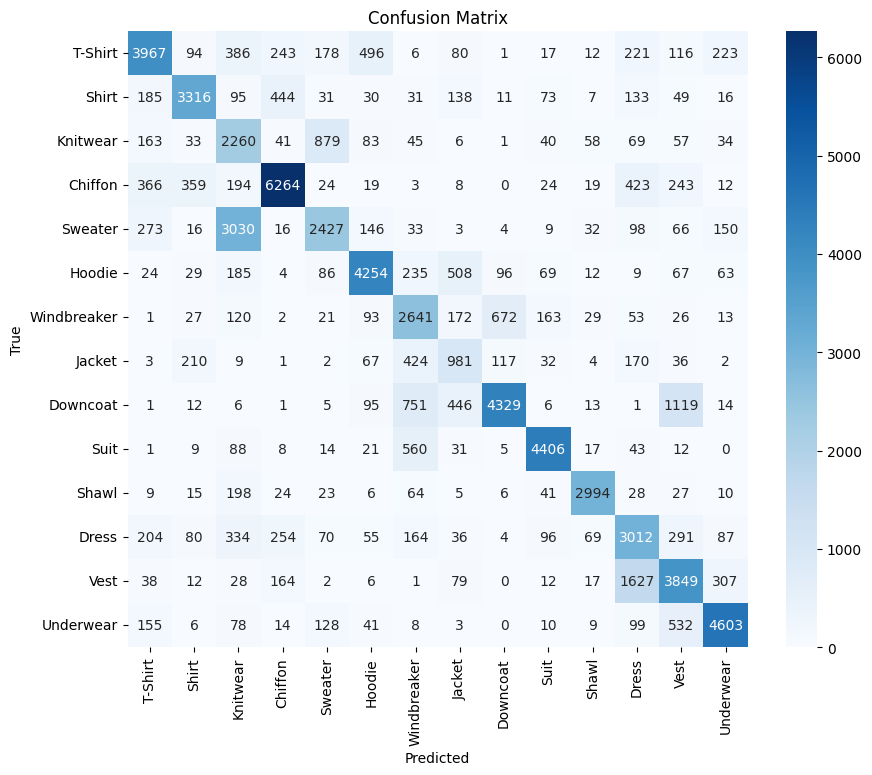

In [9]:
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
from config import class_names

# Function to generate predictions and true labels from the test loader
def get_predictions_and_labels(model, test_loader):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    return all_preds, all_labels

# Generate predictions and true labels
preds, labels = get_predictions_and_labels(standard_model, test_loader)

# Calculate confusion matrix
cm = confusion_matrix(labels, preds)

# Export confusion matrix as a CSV file
cm_df = pd.DataFrame(cm)
cm_path = f"{dataset_root}confusion_matrix_standard.csv".replace("../","/content/")
cm_df.to_csv(cm_path, index=False)
files.download(cm_path)
# Function to visualize the confusion matrix
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(cm, class_names)